# Backtesting

### BUSI 722: Data-Driven Finance II
### Kerry Back, Rice University

In [4]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")

## Create dataset of returns and features

- Do some preprocessing of target variable
  - target1 = return in excess of median each week: takes out market returns which are hard to predict
  - target2 = percentile of return each week (0=worst, 100=best): takes out market returns and reduces effect of outliers
- When evaluating performance (testing), use actual returns.

In [5]:
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver = 'SQL+Server'
string = f"mssql+pyodbc://{username}:{password}@{server}/{database}" 
try: 
    conn = create_engine(string + "?driver='SQL+Server'").connect()
except:
    try:
        conn = create_engine(string + "?driver='ODBC+Driver+18+for+SQL+Server'").connect()
    except:
        import pymssql
        string = f"mssql+pymssql://{username}:{password}@{server}/{database}"   
        conn = create_engine(string).connect() 

In [6]:
sep_weekly = pd.read_sql(
    """ 
    select date, ticker, closeadj, closeunadj, volume, lastupdated from sep_weekly 
    where date >= '2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
sep_weekly = sep_weekly.groupby(["ticker", "date"]).last()
sep_weekly = sep_weekly.drop(columns=["lastupdated"])

ret = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change()
ret.name = "ret"

price = sep_weekly.closeunadj
price.name = "price"

volume = sep_weekly.volume 
volume.name = "volume"

In [7]:
ret_annual = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(52)
ret_monthly = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(4)
mom = (1 + ret_annual) / (1 + ret_monthly) - 1
mom.name = "mom"

In [8]:
weekly = pd.read_sql(
    """ 
    select date, ticker, pb, marketcap, lastupdated from weekly 
    where date>='2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
weekly = weekly.groupby(["ticker", "date"]).last()
weekly = weekly.drop(columns=["lastupdated"])

pb = weekly.pb
pb.name = "pb" 
marketcap = weekly.marketcap 
marketcap.name = "marketcap"

In [9]:
sf1 = pd.read_sql(
    """ 
    select datekey as date, ticker, assets, netinc, equity, lastupdated from sf1
    where datekey>='2010-01-01' and dimension='ARY' and assets>0 and equity>0
    order by ticker, datekey, lastupdated    
    """,
    conn,
)
sf1 = sf1.groupby(["ticker", "date"]).last()
sf1 = sf1.drop(columns=["lastupdated"])

# change dates to Fridays
from datetime import timedelta 
sf1 = sf1.reset_index()
sf1.date =sf1.date.map(
    lambda x: x + timedelta(4 - x.weekday())
)
sf1 = sf1.set_index(["ticker", "date"])
sf1 = sf1[~sf1.index.duplicated()]

assets = sf1.assets
assets.name = "assets" 
netinc = sf1.netinc 
netinc.name = "netinc" 
equity = sf1.equity
equity.name = "equity"

equity = equity.groupby("ticker", group_keys=False).shift() 
roe = netinc / equity 
roe.name = "roe"

assetgr = assets.groupby("ticker", group_keys=False).pct_change()
assetgr.name = "assetgr"

In [43]:
df = pd.concat(
    (
        ret, 
        mom, 
        volume,
        price, 
        pb, 
        marketcap, 
        roe, 
        assetgr
        ), 
        axis=1
    )
df["ret"] = df.groupby("ticker", group_keys=False).ret.shift(-1)
df["roe"] = df.groupby("ticker", group_keys=False).roe.ffill()
df["assetgr"] = df.groupby("ticker", group_keys=False).assetgr.ffill()
df = df[df.price >= 5]
df = df.dropna()

df = df.reset_index()
df.date = df.date.astype(str)
df = df[df.date >= "2012-01-01"]

df["target1"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: x - x.median()
)
df["target2"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100*x.rank(pct=True)
)

## Train and predict

- Train periodically 
- Use trained model to predict until next training date
- First set backtest parameters and model
- Then run loop

In [44]:
train_years = 5 # num years of past data to use for training
train_freq = 3  # num years between training 
target = "target2"
features = [
    "mom",
    "volume",
    "pb",
    "marketcap",
    "roe",
    "assetgr" 
]
model = RandomForestRegressor(max_depth=3)

In [45]:
years = range(2012+train_years, 2024, train_freq)
df2 = None 
for i, year in enumerate(years):
    print(year)
    start_train = f"{year-train_years}-01-01"
    start_predict = f"{year}-01-01"
    if year == years[-1]:
        stop_predict = "2100-01-01"
    else:
        stop_predict = f"{years[i+1]}-01-01"
    past = df[(df.date >= start_train) & (df.date < start_predict)]
    future = df[(df.date>=start_predict) & (df.date<stop_predict)].copy()
    model.fit(X=past[features], y=past[target])
    future["predict"] = model.predict(X=future[features])
    df2 = pd.concat((df2, future))

df2.head()

2017
2020
2023


,ticker,date,ret,mom,volume,price,pb,marketcap,roe,assetgr,target1,target2,predict
264,A,2017-01-06,0.058225,0.103020,1987059.0,46.54,3.5,14958.1,0.110871,0.043188,0.063320,93.587302,50.563231
265,A,2017-01-13,-0.032696,0.225752,2921216.8,49.25,3.7,15488.9,0.110871,0.043188,-0.031126,16.597905,50.563231
266,A,2017-01-20,-0.006091,0.252036,1627698.5,47.64,3.7,15546.9,0.110871,0.043188,-0.006091,38.984127,50.563231
267,A,2017-01-27,0.034231,0.246427,2250481.0,47.35,3.6,15247.6,0.110871,0.043188,0.034231,85.168682,50.563231
268,A,2017-02-03,0.006120,0.248196,1921616.6,48.97,3.6,15337.7,0.110871,0.043188,0.000004,50.047755,50.563231


## Form portfolios from predictions

- Equally weighted portfolio of best stocks
- Equally weighted portfolio of worst stocks
- Equally weighted portfolio of all stocks

In [46]:
num_stocks = 50

grouped = df2.groupby("date", group_keys=False).predict
starting_from_best = grouped.rank(ascending=False, method="first")
best = df2[starting_from_best <= num_stocks]
best_rets = best.groupby("date", group_keys=True).ret.mean()
best_rets.index = pd.to_datetime(best_rets.index)

starting_from_worst = grouped.rank(ascending=True, method="first")
worst = df2[starting_from_worst <= num_stocks]
worst_rets = worst.groupby("date", group_keys=True).ret.mean()
worst_rets.index = pd.to_datetime(worst_rets.index)

all_rets = df2.groupby("date", group_keys=True).ret.mean()
all_rets.index = pd.to_datetime(all_rets.index)

## Plot performance

- Set logy = True to get a log plot.  
- In a log plot, the slope of a curve represents the percent change in the y variable per unit change in the x variable.

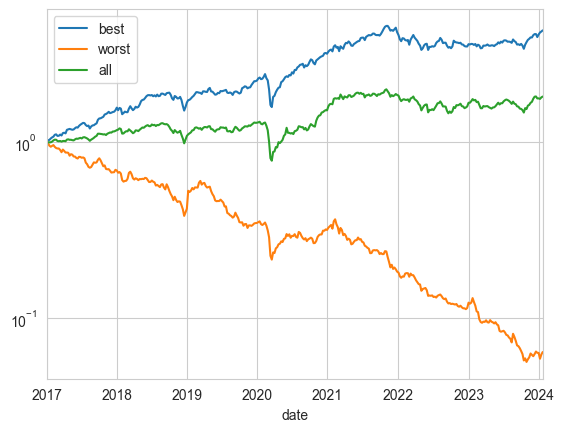

In [47]:
logy = True 

(1+best_rets).cumprod().plot(label="best", logy=logy)
(1+worst_rets).cumprod().plot(label="worst", logy=logy)
(1+all_rets).cumprod().plot(label="all", logy=logy)
plt.legend()
plt.show()

In [48]:
model.feature_importances_

array([0.04270878, 0.28977603, 0.02658673, 0.18774955, 0.45211615,
       0.00106277])